In [24]:
import pandas as pd

def csv_to_pandas(filepath):
    try:
        df = pd.read_csv(filepath)
        return df
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: File '{filepath}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: File '{filepath}' could not be parsed.")


IndentationError: unindent does not match any outer indentation level (<string>, line 13)

In [30]:
charging_sessions = csv_to_pandas("./Data Share/charging_sessions.csv")
weather_burbank_airport = csv_to_pandas("./Data Share/weather_burbank_airport.csv")
charging_sessions = charging_sessions.drop(charging_sessions.columns[0],axis=1)


                             id             connectionTime  \
6825   5d54a7cff9af8b413ec70568  2019-07-29 14:32:30+00:00   
66289  5d54a7cff9af8b413ec70568  2019-07-29 14:32:30+00:00   

                  disconnectTime           doneChargingTime  kWhDelivered  \
6825   2019-07-29 23:11:29+00:00  2019-07-29 23:12:29+00:00     43.089799   
66289  2019-07-29 23:11:29+00:00  2019-07-29 23:12:29+00:00     43.089799   

                                    sessionID  siteID  spaceID    stationID  \
6825   1_1_191_803_2019-07-29 14:32:30.059956       1  AG-4F49  1-1-191-803   
66289  1_1_191_803_2019-07-29 14:32:30.059956       1  AG-4F49  1-1-191-803   

                  timezone  userID  \
6825   America/Los_Angeles   528.0   
66289  America/Los_Angeles   528.0   

                                              userInputs  
6825   [{'WhPerMile': 250, 'kWhRequested': 55.0, 'mil...  
66289  [{'WhPerMile': 250, 'kWhRequested': 55.0, 'mil...  


In [15]:
numeric_cols = ['temperature', 'felt_temperature', 'windspeed', 'pressure']
weather_burbank_airport[numeric_cols] = weather_burbank_airport[numeric_cols].interpolate(method='linear')

In [16]:
print(charging_sessions["connectionTime"].min())
print(charging_sessions["connectionTime"].max())
print(charging_sessions["kWhDelivered"].max())

print(weather_burbank_airport["timestamp"].min())
print(weather_burbank_airport["timestamp"].max())
charging_sessions.info()


2018-04-25 11:08:04+00:00
2021-09-14 05:43:39+00:00
108.79724166666666
2018-01-01 08:53:00
2021-01-01 07:53:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                66450 non-null  object 
 1   connectionTime    66450 non-null  object 
 2   disconnectTime    66450 non-null  object 
 3   doneChargingTime  62362 non-null  object 
 4   kWhDelivered      66450 non-null  float64
 5   sessionID         66450 non-null  object 
 6   siteID            66450 non-null  int64  
 7   spaceID           66450 non-null  object 
 8   stationID         66450 non-null  object 
 9   timezone          66450 non-null  object 
 10  userID            49187 non-null  float64
 11  userInputs        49187 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 6.1+ MB


In [17]:
cs_min, cs_max = charging_sessions['connectionTime'].min(), charging_sessions['connectionTime'].max()
weather_min, weather_max = weather_burbank_airport['timestamp'].min(), weather_burbank_airport['timestamp'].max()

# Overlapping range
overlap_start = max(cs_min, weather_min)
overlap_end = min(cs_max, weather_max)

charging_sessions_overlap = charging_sessions[
    (charging_sessions['connectionTime'] >= overlap_start) &
    (charging_sessions['connectionTime'] <= overlap_end)
]

# Filter weather_burbank_airport to only keep timestamps in the overlap
weather_burbank_airport_overlap = weather_burbank_airport[
    (weather_burbank_airport['timestamp'] >= overlap_start) &
    (weather_burbank_airport['timestamp'] <= overlap_end)
]

In [18]:
distinct_stations = charging_sessions['stationID'].nunique()
print("Number of distinct stations:", distinct_stations)
charging_sessions.info()


Number of distinct stations: 107
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                66450 non-null  object 
 1   connectionTime    66450 non-null  object 
 2   disconnectTime    66450 non-null  object 
 3   doneChargingTime  62362 non-null  object 
 4   kWhDelivered      66450 non-null  float64
 5   sessionID         66450 non-null  object 
 6   siteID            66450 non-null  int64  
 7   spaceID           66450 non-null  object 
 8   stationID         66450 non-null  object 
 9   timezone          66450 non-null  object 
 10  userID            49187 non-null  float64
 11  userInputs        49187 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 6.1+ MB


In [19]:
import pandas as pd

# 1️⃣ Convert connectionTime to datetime
charging_sessions['connectionTime'] = pd.to_datetime(charging_sessions['connectionTime'])

# 2️⃣ Create date-related columns
charging_sessions['year'] = charging_sessions['connectionTime'].dt.year
charging_sessions['month'] = charging_sessions['connectionTime'].dt.month
charging_sessions['day'] = charging_sessions['connectionTime'].dt.day
charging_sessions['hour'] = charging_sessions['connectionTime'].dt.hour

# =======================
# 3️⃣ Hourly aggregation
# =======================
hourly_kwh = charging_sessions.groupby(
    ['siteID', 'year', 'month', 'day', 'hour'], as_index=False
)['kWhDelivered'].sum()
hourly_kwh.rename(columns={'kWhDelivered': 'kWh_hourly'}, inplace=True)

# =======================
# 4️⃣ Daily aggregation
# =======================
daily_kwh = charging_sessions.groupby(
    ['siteID', 'year', 'month', 'day'], as_index=False
)['kWhDelivered'].sum()
daily_kwh.rename(columns={'kWhDelivered': 'kWh_daily'}, inplace=True)

# =======================
# 5️⃣ Monthly aggregation
# =======================
monthly_kwh = charging_sessions.groupby(
    ['siteID', 'year', 'month'], as_index=False
)['kWhDelivered'].sum()
monthly_kwh.rename(columns={'kWhDelivered': 'kWh_monthly'}, inplace=True)

# =======================
# 6️⃣ Optional: check results
# =======================
print("Hourly:")
print(hourly_kwh.head())

print("\nDaily:")
print(daily_kwh.head())

print("\nMonthly:")
print(monthly_kwh.head())



Hourly:
   siteID  year  month  day  hour  kWh_hourly
0       1  2018      9    5    11      16.697
1       1  2018      9    5    12      18.054
2       1  2018      9    5    13      75.648
3       1  2018      9    5    14      47.951
4       1  2018      9    5    16       8.595

Daily:
   siteID  year  month  day  kWh_daily
0       1  2018      9    5    245.799
1       1  2018      9    6    441.490
2       1  2018      9    7    462.517
3       1  2018      9    8     49.125
4       1  2018      9    9     22.435

Monthly:
   siteID  year  month   kWh_monthly
0       1  2018      9   9514.851000
1       1  2018     10  18161.496291
2       1  2018     11  15311.232726
3       1  2018     12  14177.875000
4       1  2019      1  19688.372000


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


C:\Users\miche\AppData\Local\Temp\ipykernel_31164\2025216285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_data['datetime'] = pd.to_datetime(hourly_data[['year','month','day','hour']])


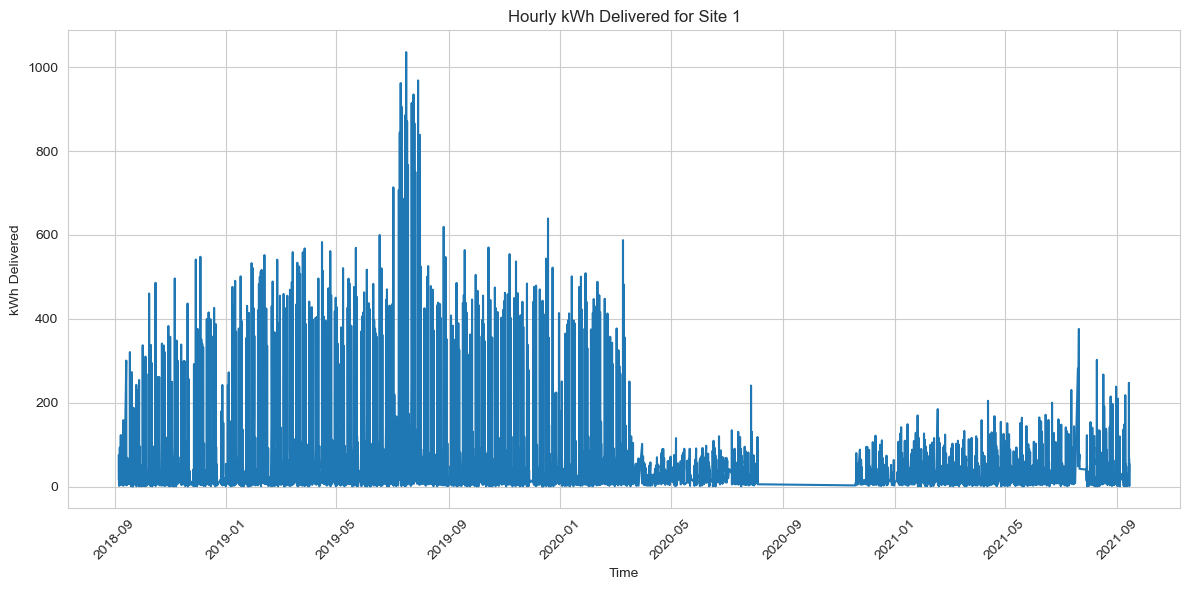

In [21]:
# Example: pick a single site to visualize (e.g., siteID = 1)
site_id = hourly_kwh['siteID'].unique()[0]
hourly_data = hourly_kwh[hourly_kwh['siteID'] == site_id]

# Create a datetime column for plotting
hourly_data['datetime'] = pd.to_datetime(hourly_data[['year','month','day','hour']])

# Line plot
plt.figure()
sns.lineplot(x='datetime', y='kWh_hourly', data=hourly_data)
plt.title(f'Hourly kWh Delivered for Site {site_id}')
plt.xlabel('Time')
plt.ylabel('kWh Delivered')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\miche\AppData\Local\Temp\ipykernel_31164\3123771013.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_data['datetime'] = pd.to_datetime(hourly_data[['year','month','day','hour']])


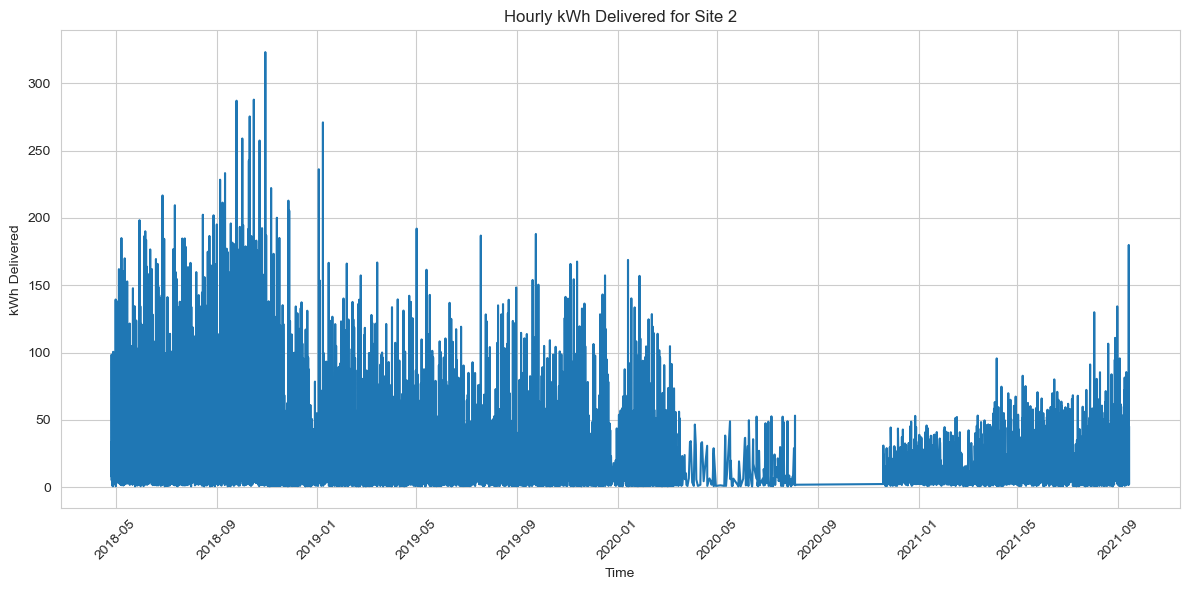

In [31]:
# Example: pick a single site to visualize (e.g., siteID = 1)
site_id = hourly_kwh['siteID'].unique()[1]
hourly_data = hourly_kwh[hourly_kwh['siteID'] == site_id]

# Create a datetime column for plotting
hourly_data['datetime'] = pd.to_datetime(hourly_data[['year','month','day','hour']])

# Line plot
plt.figure()
sns.lineplot(x='datetime', y='kWh_hourly', data=hourly_data)
plt.title(f'Hourly kWh Delivered for Site {site_id}')
plt.xlabel('Time')
plt.ylabel('kWh Delivered')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
